<a href="https://colab.research.google.com/github/jvitorfernandes/Caravan/blob/master/Planoly_Analytics_Home_Assignment_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analytics on Event Data



### 1. Which are the top 10 account ids by number of users?


```sql
select account_id,
       SUM(DISTINCT user_id) as total_unique_users
from tasks_used_da
group by account_id
order by total_unique_users DESC
limit 10;
```

| account\_id | total\_unique\_users |
| :--- | :--- |
| -1 | 6320790879 |
| 2101269 | 234817932 |
| 2074697 | 49492056 |
| 1215768 | 31096986 |
| 2147969 | 31045595 |
| 2284259 | 27587259 |
| 1675574 | 25020911 |
| 2165388 | 22796722 |
| 2258002 | 20351258 |
| 2187586 | 18773338 |



### 2. Create a summary table at the account level that signals when an account is new (boolean). An account is new for the first day we see it run a task(s).



```sql
CREATE TABLE new_accounts AS
SELECT tuda.date,
       tuda.account_id,
       SUM(tuda.sum_tasks_used) as tasks,
       m_date.is_new
FROM tasks_used_da AS tuda
LEFT JOIN (SELECT MIN(date) AS min_date,
              account_id,
              't' as is_new
          FROM tasks_used_da
          WHERE sum_tasks_used > 0
          GROUP BY account_id) AS m_date
ON tuda.date = m_date.min_date AND tuda.account_id = m_date.account_id
GROUP BY tuda.account_id, tuda.date, m_date.is_new
ORDER BY tuda.date;

UPDATE new_accounts
SET is_new = 't'
WHERE is_new IS NULL;
```


>  ⚠ This will assume a lot of accounts were created on January 2017 since we don't have data before this date.

We can take a peak at the table that was just created:

```sql
SELECT *
FROM new_accounts
ORDER BY date, account_id
LIMIT 50;
```

| date | account\_id | tasks | is\_new |
| :--- | :--- | :--- | :--- |
| 2017-01-01 | -1 | 8305 | t |
| 2017-01-01 | 1 | 48 | t |
| 2017-01-01 | 2 | 291 | t |
| 2017-01-01 | 3 | 6 | t |
| 2017-01-01 | 14 | 16 | t |
| 2017-01-01 | 50 | 9 | t |
| 2017-01-01 | 64 | 0 | f |
| 2017-01-01 | 71 | 1 | t |

### 5. A lost account is an account with no tasks run on a given month. How many accounts did we lose (had no executed tasks) in February 2017?

```sql
SELECT COUNT(*)
FROM (SELECT account_id,
             DATE_PART('month', date) AS month,
             DATE_PART('year', date)  AS year,
             SUM(sum_tasks_used)      AS tasks
      FROM tasks_used_da
      WHERE DATE_PART('month', date) = 2
        AND DATE_PART('year', date) = 2017
      GROUP BY account_id, month, year
      HAVING tasks <= 0
) AS no_tasks_on_feb_2017;
```

| count |
| :--- |
| 13756 |

### 6. Create a visualization that represents the growth of new accounts in a way you would communicate to a peer or business stakeholder.

```sql 
SELECT COUNT(account_id) as total_new_accounts,
     DATE_PART('week', date) AS week,
     DATE_PART('month', date) AS month,
     DATE_PART('year', date)  AS year
FROM new_accounts
WHERE is_new = 't'
AND week NOT IN (1, 52)
GROUP BY  week, month, year
ORDER BY  week, month;
```

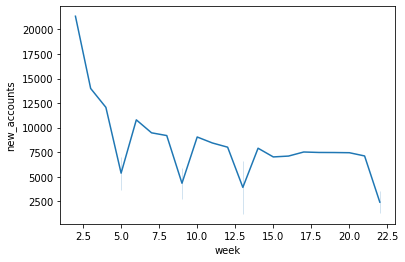

| total\_new\_accounts | week | month | year |
| :--- | :--- | :--- | :--- |
| 21348 | 2 | 1 | 2017 |
| 13991 | 3 | 1 | 2017 |
| 12067 | 4 | 1 | 2017 |
| 3681 | 5 | 1 | 2017 |
| 7050 | 5 | 2 | 2017 |
| 10794 | 6 | 2 | 2017 |
| 9474 | 7 | 2 | 2017 |
| 9194 | 8 | 2 | 2017 |
| 2780 | 9 | 2 | 2017 |
| 5894 | 9 | 3 | 2017 |
| 9048 | 10 | 3 | 2017 |
| 8438 | 11 | 3 | 2017 |
| 8010 | 12 | 3 | 2017 |
| 6620 | 13 | 3 | 2017 |
| 1213 | 13 | 4 | 2017 |
| 7905 | 14 | 4 | 2017 |
| 7018 | 15 | 4 | 2017 |
| 7105 | 16 | 4 | 2017 |
| 7520 | 17 | 4 | 2017 |
| 7473 | 18 | 5 | 2017 |
| 7466 | 19 | 5 | 2017 |
| 7447 | 20 | 5 | 2017 |
| 7117 | 21 | 5 | 2017 |
| 3536 | 22 | 5 | 2017 |
| 1286 | 22 | 6 | 2017 |


# Exploring Data

In [22]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import text
import seaborn as sns
import getpass

In [24]:
print("Enter the redshift endpoint URL")
redshift_endpoint = getpass.getpass()
print("Enter the redshift username")
redshift_user = getpass.getpass()
print("Enter the redshift password")
redshift_pass = getpass.getpass()
print("Enter the port number")
port = getpass.getpass()
print("Enter the db name")
dbname = getpass.getpass()

Enter the redshift endpoint URL


KeyboardInterrupt: ignored

In [26]:
from sqlalchemy import create_engine
from sqlalchemy import text
engine_string = "postgresql+psycopg2://%s:%s@%s:%d/%s" \
% (redshift_user, redshift_pass, redshift_endpoint, int(port), dbname)
engine1 = create_engine(engine_string)

In [30]:
sql = """
  SELECT COUNT(account_id) as new_accounts,
      DATE_PART('week', date) AS week,
      DATE_PART('month', date) AS month,
      DATE_PART('year', date)  AS year
  FROM new_accounts
  WHERE is_new = 't'
  AND week NOT IN (1, 52)
  GROUP BY  week, month, year
  ORDER BY  week, month;
"""

In [33]:
df1 = pd.read_sql_query(text(sql), engine1)
df1

,new_accounts,week,month,year
0,21348,2.0,1.0,2017.0
1,13991,3.0,1.0,2017.0
2,12067,4.0,1.0,2017.0
3,3681,5.0,1.0,2017.0
4,7050,5.0,2.0,2017.0
5,10794,6.0,2.0,2017.0
6,9474,7.0,2.0,2017.0
7,9194,8.0,2.0,2017.0
8,2780,9.0,2.0,2017.0
9,5894,9.0,3.0,2017.0


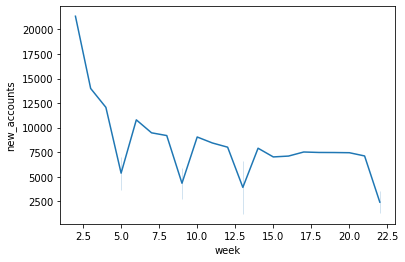

In [32]:
sns.lineplot(data=df1, x="week", y="new_accounts")